In [1]:
# Third party
import cv2
from fastdtw import fastdtw

import matplotlib.pyplot as plt
import matplotlib_inline

import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.manifold import TSNE

from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing import image

# Local
import flexibleSubsetSelection as fss

# Initialize notebook settings
sns.set_theme() # set seaborn theme
matplotlib_inline.backend_inline.set_matplotlib_formats('svg') # vector plots
%matplotlib inline 
%load_ext autoreload
%autoreload 2

ModuleNotFoundError: No module named 'cv2'

In [2]:
video_path = '../data/exampleDatasets/dance.mp4'
cap = cv2.VideoCapture(video_path)

# Check that video was opened successfully
if not cap.isOpened():
    print("Error: Could not open video.")
    exit()

# Initialize the pre-trained ResNet50 model
model = ResNet50(weights='imagenet', include_top=False, pooling='avg')

frames = []
frame_count = 0
max_frames = 1000  # Adjust this to limit the number of frames for t-SNE

# Read video frames
while cap.isOpened() and frame_count < max_frames:
    ret, frame = cap.read()
    if ret:
        # Convert BGR to RGB
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frames.append(frame)
        frame_count += 1
    else:
        break

cap.release()

# Preprocess frames for the neural network
processed_frames = []
for frame in frames:
    img = cv2.resize(frame, (224, 224))  # Resize frame to fit the model's expected input size
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = preprocess_input(img)
    processed_frames.append(img)

# Stack frames into a single numpy array
processed_frames = np.vstack(processed_frames)

# Extract features using ResNet50
features = model.predict(processed_frames)

# Apply t-SNE
tsne = TSNE(n_components=1, random_state=0)
tsne_results = tsne.fit_transform(features)

NameError: name 'cv2' is not defined

In [11]:
df = pd.DataFrame(tsne_results, columns=['Values'])
df['Frame'] = df.index

dataset = fss.Dataset(data=df)

(20, 2)


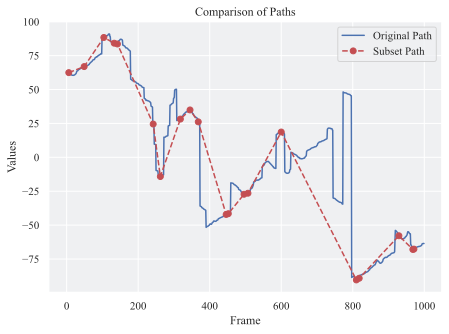

DTW distance between paths: 9258.398311872035


In [42]:
subset_df = df.sample(frac=.02, random_state=1).sort_index()
print(subset_df.shape)

plt.plot(df['Frame'], df['Values'], label='Original Path')
plt.plot(subset_df['Frame'], subset_df['Values'], 'ro--', label='Subset Path')
plt.xlabel('Frame')
plt.ylabel('Values')
plt.legend()
plt.title('Comparison of Paths')
plt.show()

original_sequence = df['Values'].tolist()
subset_sequence = subset_df['Values'].tolist()

distance, path = fastdtw(original_sequence, subset_sequence)

print("DTW distance between paths:", distance)

In [46]:
s = 20

z, timeTotal, loss = approximation.greedySwap(dataset, s=s, objective=objectives.dtw)
subset = sets.Subset(dataset, z, length=s)
print(loss)

with open('size={s}_obj=dtw_k=full.pkl', 'wb') as f:
    pickle.dump(subset, f)

0: 328.14849839048014
1: 323.4735766526782
2: 323.3134676348862
3: 323.2243274560927
4: 323.16118891362584
5: 323.01741714140513
6: 322.8929582004841
7: 322.71923600677616
8: 322.6914821954951
9: 322.5422456801669
10: 322.4401838870163
11: 322.38449167043444
12: 322.3702984191262
13: 322.3620116747971
14: 322.3620116747971
15: 322.3620116747971
16: 322.3620116747971
17: 322.3620116747971
18: 322.3620116747971
19: 322.3620116747971
20: 322.3620116747971
21: 322.3620116747971
22: 322.3620116747971
23: 322.3620116747971
24: 322.3620116747971
25: 322.3620116747971
26: 322.3620116747971
27: 322.3620116747971
28: 322.3620116747971
29: 322.2986551168661
30: 322.2454268422542
31: 322.2284673520307
32: 322.2187567798978
33: 322.2086116993733
34: 322.2086116993733
35: 322.2086116993733
36: 322.2086116993733
37: 322.2086116993733
38: 322.2086116993733
39: 322.2086116993733
40: 322.2086116993733
41: 322.2086116993733
42: 322.2086116993733
43: 322.2086116993733
44: 322.2086116993733
45: 322.2086116

In [36]:
from fastdtw import fastdtw

# Original path
original_path = [(0, 0), (1, 5), (2, 0)]

# Subset path
subset_path = [(0, 0), (1, 4), (2, 0)]

# Calculate DTW distance
distance, path = fastdtw(original_path, subset_path)

print("DTW distance between paths:", distance)

DTW distance between paths: 1.0


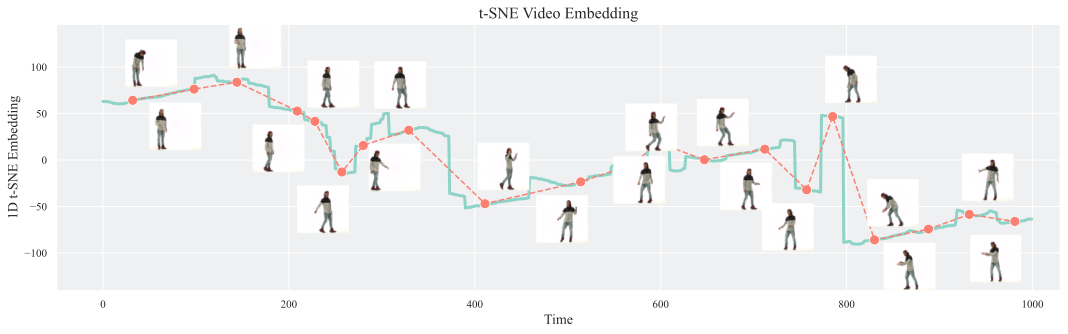

In [150]:
import matplotlib.pyplot as plt
import seaborn as sns

scale = 0.07
xshift = 20
yshift = 40

samples = 6
sampled_indices = subset.df["Frame"]
sampled_frames = [frames[i] for i in sampled_indices]

# Create a figure and an axis for the plot
fig, ax = plt.subplots(figsize=(15, 5))

# Plot t-SNE embedding
ax.plot(range(len(tsne_results)), 
        tsne_results, 
        color=color["green"], 
        lw=3) 

for j, (i, frame) in enumerate(zip(sampled_indices, sampled_frames)):
    height, width, _ = frame.shape
    crop_height = height  # Retain the full height
    crop_width = int(height * 1.1)  # Retain the width proportionally
    
    # Ensure the cropped width does not exceed the original width
    if crop_width > width:
        crop_width = width
    
    # Calculate the left offset to crop equally from both sides
    left_offset = (width - crop_width) // 2
    
    # Crop the image to a rectangle
    cropped_image = frame[:, left_offset:left_offset + crop_width, :]  # Cropping to a rectangle
    
    if j == 7:  # Move every other image above
        extent = (i - crop_width*scale - xshift + 5, 
                  i + crop_width*scale - xshift + 5, 
                  tsne_results[i] - crop_height*scale - yshift, 
                  tsne_results[i] + crop_height*scale - yshift)
    elif j == 6:  # Move every other image above
        extent = (i - crop_width*scale + xshift*2, 
                  i + crop_width*scale + xshift*2, 
                  tsne_results[i] - crop_height*scale + yshift + 25, 
                  tsne_results[i] + crop_height*scale + yshift + 25)
    elif j==8:  # Move every other image above
        extent = (i - crop_width*scale + xshift, 
                  i + crop_width*scale + xshift, 
                  tsne_results[i] - crop_height*scale + yshift, 
                  tsne_results[i] + crop_height*scale + yshift)
    # elif j==11:  # Move every other image above
    #     extent = (i - crop_width*scale + xshift, 
    #               i + crop_width*scale + xshift, 
    #               tsne_results[i] - crop_height*scale - yshift, 
    #               tsne_results[i] + crop_height*scale - yshift)
    elif (j % 2 == 0 or j == 15) and j != 14:  # Move every other image above
        extent = (i - crop_width*scale + xshift, 
                  i + crop_width*scale + xshift, 
                  tsne_results[i] - crop_height*scale + yshift, 
                  tsne_results[i] + crop_height*scale + yshift)
    else:
        extent = (i - crop_width*scale - xshift, 
                  i + crop_width*scale - xshift, 
                  tsne_results[i] - crop_height*scale - yshift, 
                  tsne_results[i] + crop_height*scale - yshift)
    
    ax.imshow(cropped_image, extent=extent, alpha=1, zorder=3)

ax.set_title('t-SNE Video Embedding', fontsize=titleSize)
ax.set_xlabel('Time', fontsize=labelSize)
ax.set_ylabel('1D t-SNE Embedding', fontsize=labelSize)

# Adjusting plot limits
ax.set_xlim([0 - 50, len(frames) + 30])
ax.set_ylim([tsne_results.min() - 50, tsne_results.max() + 55])

sns.scatterplot(data=subset.df,
                x="Frame",
                y="Values",
                color=color["orange"],
                s=100,  # Marker size
                zorder=2,
                ax=ax)

# Create a line plot with a dotted line
sns.lineplot(data=subset.df, 
             x="Frame",
             y="Values",
             color=color["orange"],
             linestyle="--",
             ax=ax)

plt.savefig("motion.pdf", bbox_inches="tight")


16/16 ━━━━━━━━━━━━━━━━━━━━ 28s 2s/step


Text(0, 0.5, 't-SNE Dimension 2')

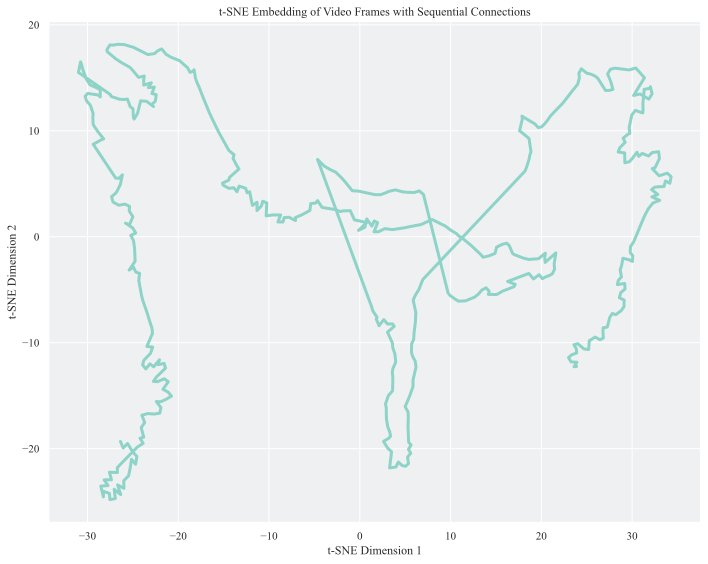

In [81]:
video_path = 'datasets/dance.mp4'
cap = cv2.VideoCapture(video_path)

# Check that video was opened successfully
if not cap.isOpened():
    print("Error: Could not open video.")
    exit()

# Initialize the pre-trained ResNet50 model
model = ResNet50(weights='imagenet', include_top=False, pooling='avg')

frames = []
frame_count = 0
max_frames = 500  # Adjust this to limit the number of frames for t-SNE

# Read video frames
while cap.isOpened() and frame_count < max_frames:
    ret, frame = cap.read()
    if ret:
        # Convert BGR to RGB
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frames.append(frame)
        frame_count += 1
    else:
        break

cap.release()

# Preprocess frames for the neural network
processed_frames = []
for frame in frames:
    img = cv2.resize(frame, (224, 224))  # Resize frame to fit the model's expected input size
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = preprocess_input(img)
    processed_frames.append(img)

# Stack frames into a single numpy array
processed_frames = np.vstack(processed_frames)

# Extract features using ResNet50
features = model.predict(processed_frames)

# Apply t-SNE
tsne = TSNE(n_components=2, random_state=0)
tsne_results = tsne.fit_transform(features)

# Plot t-SNE embedding
plt.figure(figsize=(10, 8))
plt.plot(tsne_results[:, 0], 
         tsne_results[:, 1], 
         color=color["green"], 
         lw=3)

plt.title('t-SNE Embedding of Video Frames with Sequential Connections')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')